In [1]:
# Importing required modules
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

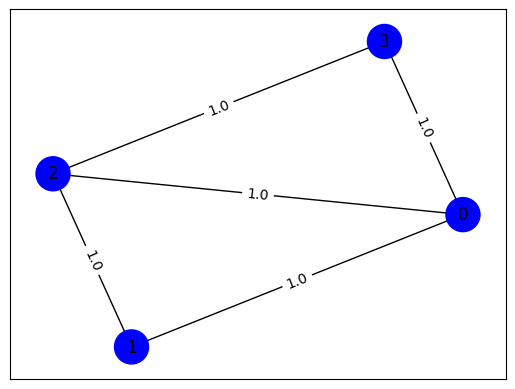

In [2]:
# Generating a graph of 4 nodes

n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_weighted_edges_from(elist)

colors = ["b" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [3]:
weight_matrix = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            weight_matrix[i, j] = temp["weight"]

In [4]:
max_cut = Maxcut(weight_matrix)
quadratic_program = max_cut.to_quadratic_program()
print(quadratic_program.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [5]:
qubitOp, offset = quadratic_program.to_ising()
print("Offset: ", offset)
print("Ising hamiltonian: ")
print(str(qubitOp))

Offset:  -2.5
Ising hamiltonian: 
0.5 * IIZZ
+ 0.5 * IZIZ
+ 0.5 * IZZI
+ 0.5 * ZIIZ
+ 0.5 * ZZII


In [6]:
exact_solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact_solver.solve(quadratic_program)
print(result.prettyprint())

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


In [7]:
algorithm_globals.random_seed = 17
seed = 10256
backend = Aer.get_backend("aer_simulator_statevector")

In [8]:
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

spsa = SPSA(maxiter=80)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=3, entanglement="circular")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

In [9]:
result = vqe.compute_minimum_eigenvalue(qubitOp)

In [10]:
X = max_cut.sample_most_likely(result.eigenstate)

In [11]:
print("Energy: ", result.eigenvalue.real)
print("Obj: ", result.eigenvalue.real + offset)
print("Solution: ", X)
print("Solution objective: ", quadratic_program.objective.evaluate(X))

Energy:  -1.4942253100296412
Obj:  -3.994225310029641
Solution:  [0. 1. 0. 1.]
Solution objective:  4.0
